# Group significantly clustered motifs into motif families
This notebook takes for input a similarity matrix (.tsv) that compares the overlap of proteins associated to significantly clustered motifs. This notebook performs hierarchical clustering of motifs and visualizes the similarity as a dendrogram. Users can test different clustering methods, as well as different thresholds or cut in the tree, to determine the ideal number of motif families based on the seperation of branches.

In [1]:
#Package dependencies
packages = c("dendextend", "cluster", "data.table", "RColorBrewer", "shiny", "miniUI")

package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      suppressPackageStartupMessages(library(x, character.only = TRUE))
    }
  })

Loading required package: dendextend


---------------------
Welcome to dendextend version 1.17.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree


Loading required package: cluster

Loading required package: data.table


Attaching package: ‘data.table’


The following object is masked from ‘package:dendextend’:

    set


Loading required package: RColorBrewer

Loading required package: shiny

Loading required package: 

## Load similarity matrix
Please specify file path and name of your matrix. The similarity matrix is generated 


In [7]:
########################################################
### specify file name for similarity matrix ############

working_directory <- "/path/to/project/motifFamilies/all/"
matrixFile <- "DistanceMatrix.tsv"
motifsFile <- "MotifsInMatrix.tsv"

########################################################

setwd(working_directory)
dm <- as.matrix(fread(matrixFile, sep = "\t", header = F))
dm2 <- dm[,-ncol(dm)]
dm_dist <- as.dist(dm2)
cat("Loaded matrix has : ", dim(dm2)[1], " motifs")

Loaded matrix has :  13  motifs

## Select clustering method
You will be directed to a new tab / pop-up to select the clustering measure


Listening on http://127.0.0.1:6626



You picked: ward.D2 
Plot saved as dendrogram1_ward.D2.png 


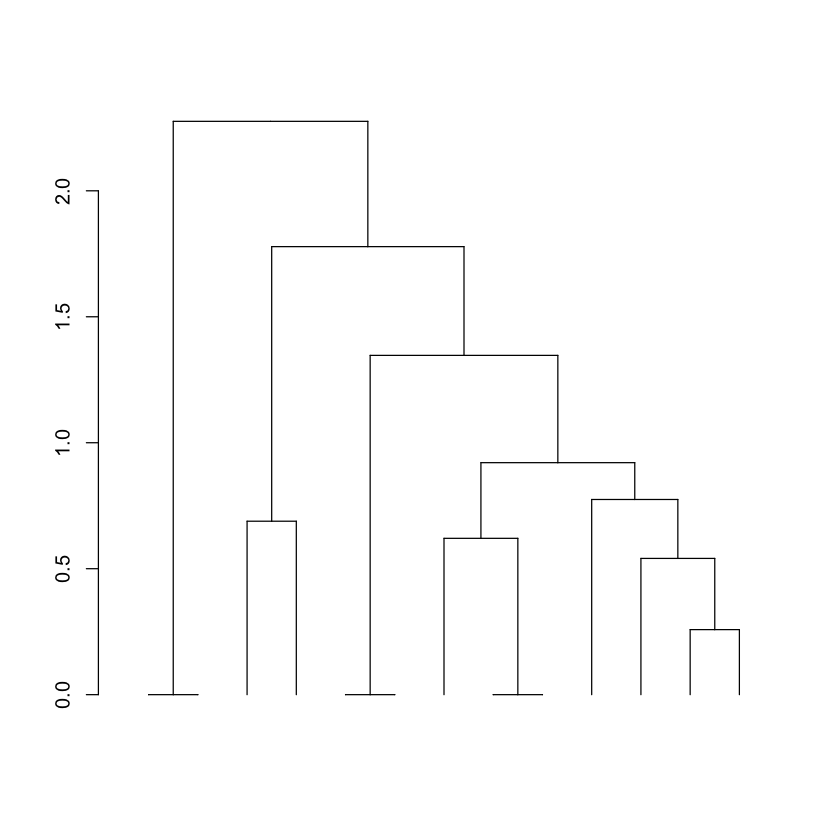

In [4]:
my_gadget <- function() {
    ui <- miniPage(
    gadgetTitleBar("Select a clustering measure"),
    miniContentPanel(
      selectInput("clust", "Choice:", c("ward.D2", "complete", "single", "average")),
      verbatimTextOutput("value")
    )
  )
  
  server <- function(input, output, session) {
    output$value <- renderText({ input$clust })
    observeEvent(input$done, {
      stopApp(input$clust)  # Returns the selected value to R
    })
  }
  runGadget(ui, server)
}

chosen_value <- my_gadget()
clustering_measure <- chosen_value
cat("You picked:", chosen_value, "\n")

file_name <- paste0("dendrogram1_", clustering_measure, ".png")
dend <- hclust(dm_dist, method = clustering_measure)%>% 
  as.dendrogram %>% 
  set_labels(rep("",length(dm_dist))) %>%
  plot()

# plot is output as png by default - other possible types = pdf, svg
if (file_name != "") {
  dev.copy(png, filename = file_name, res=400, units = "in", width = 10, height = 7)
  dev.off()
  cat("Plot saved as", file_name, "\n")
}

## Explore tree-heights
Based on the height of your tree, select an optimal height range.

quartz_off_screen 
                3

pdf 
  2

Plot saved as dendrogram2_0.5_1.5_0.25.png 


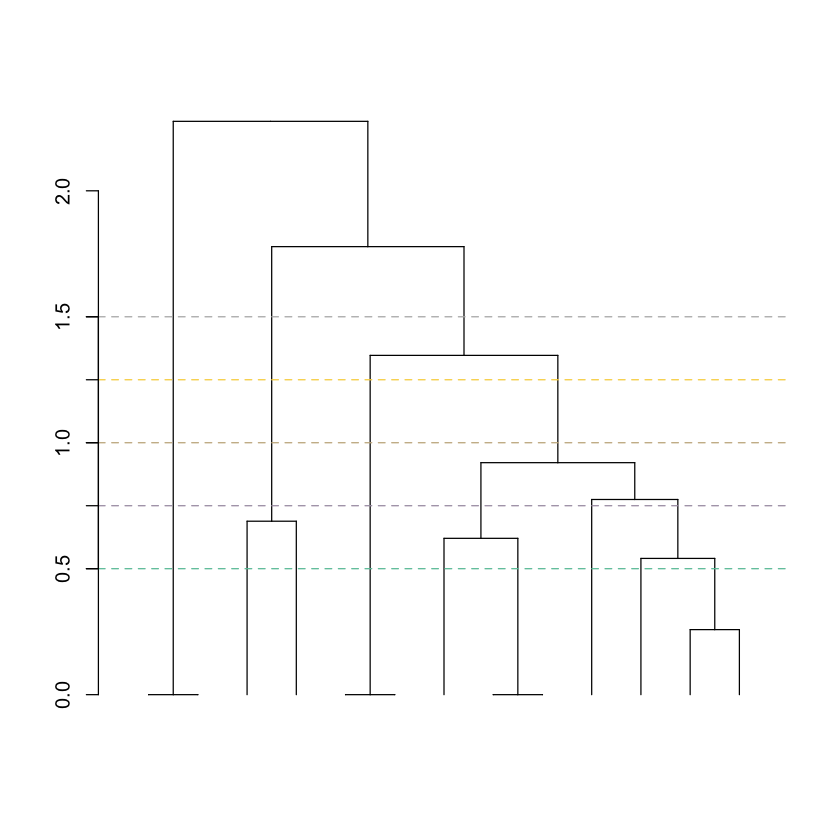

In [5]:
###################################################
### users should specify thresholds to evaluate ###

lowerLimit <- 0.5
upperLimit <- 1.5
interval <- 0.25

##################################################

dend <- hclust(dm_dist, method = clustering_measure)

v <- seq(as.double(lowerLimit), as.double(upperLimit), as.double(interval))
dm <- as.data.frame(v)
f <- function(x) {length(table(cutree(dend, h=x)))}
dm$groupSize <- apply(dm, 1, f)

# Plot dendrogram
dend2 <- hclust(dm_dist, method = clustering_measure)%>% 
  as.dendrogram %>% 
  set_labels(rep("",length(dm_dist))) %>%
  plot()%>%
  abline(h = v, lty = 2, col= colorRampPalette(brewer.pal(8, "Set2"))(length(v)))%>%
  text(x = ncol(dm2) + 20, y = v, labels = dm$groupSize, cex = 1) %>%
  axis(side = 2, at = v, labels = F)

file_name <- paste0("dendrogram2_", lowerLimit, "_", upperLimit, "_", interval, ".png")
dev.copy(png, filename = file_name, res=400, units = "in", width = 10, height = 7)
dev.off()
cat("Plot saved as", file_name, "\n")

## Plot final dendrogram
Select the height in the tree from which to extract motif families. A final dedrogram will be created with colour-coded branches indicating seperate groups. Individual files for each group will be generated, listing motifs in each family.

quartz_off_screen 
                3

pdf 
  2

Plot saved as dendrogram3_ward.D2_h0.75.png 


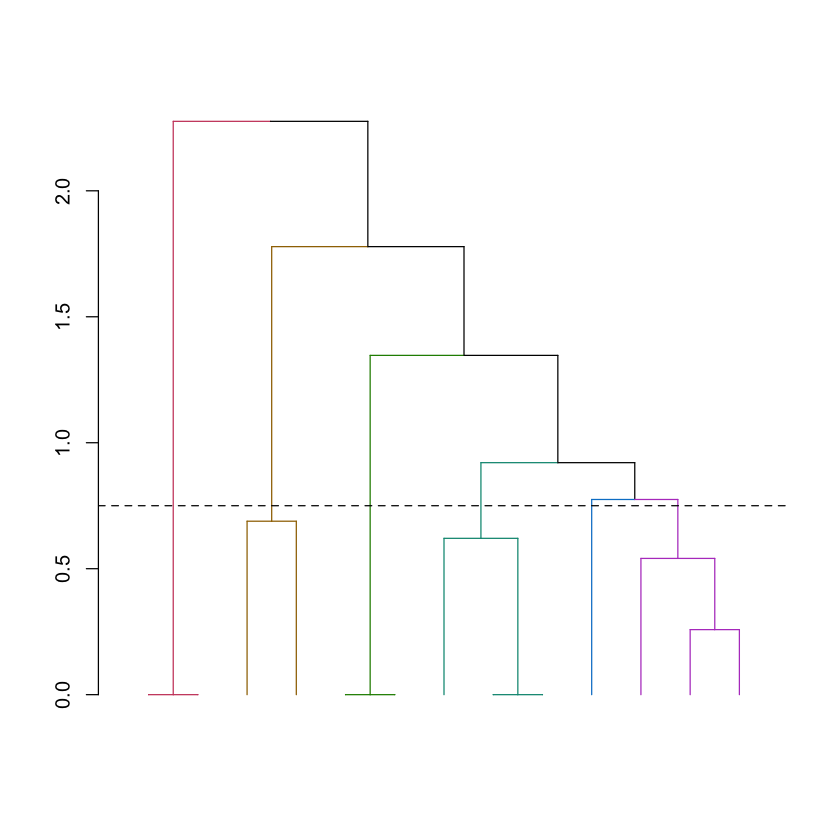

In [8]:
################################################
### users should specify height to evaluate ###

height<-0.75

################################################

dend <- hclust(dm_dist, method = clustering_measure) %>% 
  as.dendrogram %>% 
  set_labels(rep("",length(dm_dist))) %>%
  color_branches(h=height) %>% 
  plot()%>%
  abline(h = height, lty = 2, col="black")

file_name <- paste0("dendrogram3_", clustering_measure, "_h", height,".png")
dev.copy(png, filename = file_name, res=400, units = "in", width = 10, height = 7)
dev.off()
cat("Plot saved as", file_name, "\n")

# Obtain motif families
groupsFile <- paste0("MotifFamily_h", height, "_group")

dend <- hclust(dm_dist, method = clustering_measure)
groups<-cutree(dend, h= height)
motifs <- as.vector(read.csv(motifsFile, header = F))
motifs$group<- groups

for (i in c(1:length(table(groups)))){
  groupX <- motifs$V1[motifs$group == i]
  fileName = paste(groupsFile, i, ".tsv", sep = "")
  write.table(groupX, fileName, sep = "\t", quote= F, col.names = F, row.names = F)
}